# Laboratorio 5: SVMs

- Martínez Ostoa Néstor
- Aprendizaje de Máquina
- LCD - IIMAS - UNAM
- Octubre 2021

---

**Instrucciones:**

1. Desarrollar en python utilizando Pytorch el clasificador de margen suave
2. Generar dos conjuntos de datos de 500 elementos cada uno, en dos dimensiones. Uno de ellos debe estar centrado en $[-1, -1]$ y otro en $[1, 1]$. Los parámetros utilizados para la generación de datos
3. Repartir los datos en un split de $70-30\%$
4. Entrenar el algoritmo desarrollado con el $70\%$
5. Reportar el valor de accuracy del método con el $30\%$ restante de los datos

In [93]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

## Clasificador de margen suave

Función de costo $L$:

$$L=\min_{w,b}||w||^2 + C\left[ \frac{1}{n}\sum_{i=1}^n\max(0,1-y_i(w\cdot x_i+b)) \right]$$

- [Referencia](https://github.com/juliusberner/svm_tf_pytorch/blob/master/svm_tf_pytorch.ipynb)

In [180]:
# t equivale a y_i(wx_i + b)
def hinge_loss(t):
    loss = 1-t
    loss[loss<0] = 0
    return loss

## Generación de datos

Generar dos conjuntos de datos de 500 elementos cada uno, en dos dimensiones. Uno de ellos debe estar centrado en $[-1, -1]$ y otro en $[1, 1]$. Los parámetros utilizados para la generación de datos

In [46]:
torch.manual_seed(0)

std = 0.65
num_data = 500

x1 = torch.normal(1, std, size=(num_data,2))
y1 = torch.ones(num_data,1)

x2 = torch.normal(-1, std, size=(num_data, 2))
y2 = -1*torch.ones(num_data,1)

X = torch.cat((x1, x2), 0)
y = torch.cat((y1, y2), 0)

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")

Dimensiones de X: torch.Size([1000, 2])
Dimensiones de y: torch.Size([1000, 1])


In [47]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x1[:,0], y=x1[:,1],mode='markers'))
fig.add_trace(go.Scatter(x=x2[:,0], y=x2[:,1],mode='markers'))
fig.update_layout(template="plotly_white")
fig.show()

## División de datos
 Repartir los datos en un split de $70-30\%$

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: torch.Size([700, 2])
y_train shape: torch.Size([700, 1])
X_test shape: torch.Size([300, 2])
y_test shape: torch.Size([300, 1])


## Entrenamiento del modelo

In [207]:
train_dataloader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=10)
model = torch.nn.Linear(2,1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [208]:
def train(dataloader, model, optimizer, C, n_epochs=100, verbose=False):
    for i in range(n_epochs):
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = (model.weight**2).sum() + C*hinge_loss(pred*y_batch).mean()
            loss.backward()
            optimizer.step()
        if verbose: print(f"Epoch #{i}, Loss: {loss.item()}")
    return loss

In [221]:
C = 0.8
loss = train(train_dataloader, model, optimizer, C, n_epochs=100)
print(f"Loss value {round(loss.item(),4)} for C={C}")

Loss value 0.4693 for C=0.8


In [232]:
W = np.array([model.weight[0][0].item(), model.weight[0][1].item()])
b = model.bias[0].item()

print(f"Model parameters:\n\tW:{W}\n\tb:{b}")

Model parameters:
	W:[0.33494899 0.3134985 ]
	b:-0.02046266384422779


## Evaluación del modelo

In [247]:
def get_accuracy(model, X_test, y_test):
    y_pred = model(X_test)
    E = y_pred*y_test
    
    wc = E[E<0].shape[0] #wc: wrong classifications
    cc = E.shape[0] - wc #cc: correct classifications
    acc = cc / y_test.shape[0]
    
    return acc

In [248]:
acc = get_accuracy(model, X_test, y_test)
print(f"Accuracy: {acc}")

Accuracy: 0.9766666666666667


Código para graficar tomado de: [juliusberner](https://github.com/juliusberner/svm_tf_pytorch/blob/master/svm_utils.py)

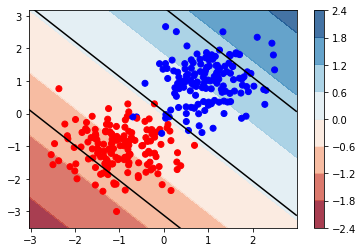

In [246]:
from svm_utils import plot
X=X_test
Y=y_test
plot(X, Y, W=model.weight.t().detach().numpy(), b=-model.bias.detach().numpy())

## Entrenamiento y evaluación con diferentes valores de $C$

C:0.1, Loss:0.1087, Accuracy: 0.4967
Model parameters: W:[0.04668533 0.04929723], b:0.6512


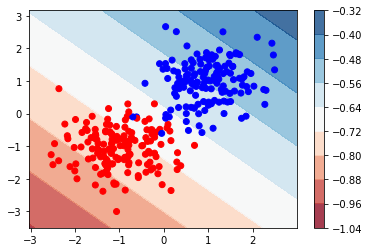

C:0.3, Loss:0.2949, Accuracy: 0.84
Model parameters: W:[0.16038492 0.14445403], b:0.2568


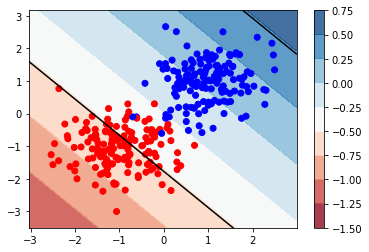

C:0.5, Loss:0.4058, Accuracy: 0.97
Model parameters: W:[0.24632747 0.20474972], b:-0.0756


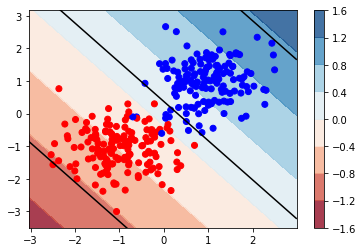

In [ ]:
Cs = [0.1, 0.3, 0.5, 0.8, 1.0]
for C in Cs:
    # Model configuration
    train_dataloader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=10)
    model = torch.nn.Linear(2,1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    # Model training and loss
    loss = train(train_dataloader, model, optimizer, C, n_epochs=100)
    W = np.array([model.weight[0][0].item(), model.weight[0][1].item()])
    b = model.bias[0].item()
    
    # Model evaluation
    acc = get_accuracy(model, X_test, y_test)
    
    # DataViz
    print(f"C:{C}, Loss:{round(loss.item(),4)}, Accuracy: {round(acc, 4)}")
    print(f"Model parameters: W:{W}, b:{round(b,4)}")
    plot(X_test, y_test, W=model.weight.t().detach().numpy(), b=-model.bias.detach().numpy())
    